In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import pickle
import astropy.units as u
import astropy.constants as const
import galsim as gs
sys.path.insert(0, "/home/jiachuan/kl-tools_spencer/kl_tools")
sys.path.insert(0, "/home/jiachuan/kl-tools_spencer/kl_tools/grism_modules")
from tngsim import TNGsimulation as ts
import cube
import emission
import grism
import priors
from emission import LINE_LAMBDAS
import kltools_grism_module_2 as m
import fsps
from tqdm import tqdm

### Retrieve the galaxy


In [2]:
### Build GrismPars object
### Initialization
sampled_pars = [
    'g1',
    'g2',
    'theta_int',
    'sini',
    'v0',
    'vcirc',
    'rscale',
    ]
sampled_pars_value = [0.0, 0.0, -1.04, 0.86, 0.0, 300.0, 0.5]
sampled_pars_value_dict = {k:v for k,v in zip(sampled_pars, sampled_pars_value)}
meta_pars = {
    'g1': 'sampled',
    'g1': 'sampled',
    'theta_int': 'sampled',
    'sini': 'sampled',
    'units': {
        'v_unit': u.Unit('km/s'),
        'r_unit': u.Unit('arcsec')
        },
    'priors': {
        'g1': priors.GaussPrior(0., 0.1, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.1, clip_sigmas=2),
        'theta_int': priors.UniformPrior(-np.pi, np.pi),
        'sini': priors.UniformPrior(0, 1.),
        'v0': priors.GaussPrior(0.0, 30, clip_sigmas=5),
        #'vcirc': priors.UniformPrior(0, 800),
        'vcirc': priors.GaussPrior(300.0, 30, clip_sigmas=5),
        'rscale': priors.UniformPrior(0, 4),
        },
    'velocity': {
        'model': 'default',
        'v0': 'sampled',
        'vcirc': 'sampled',
        'rscale': 'sampled',
    },
    'intensity': {
        # For this test, use truth info
        'type': 'inclined_exp',
        'flux': 1.0, # counts
        'hlr': 0.5,
        },
    # 'marginalize_intensity': True,
    #'psf': gs.Gaussian(fwhm=0.13),
    'run_options': {
        #'remove_continuum': True,
        'use_numba': False
        },
    'model_dimension':{
        'Nx': 100,
        'Ny': 100,
        'scale': 0.0325, # arcsec
        #'lambda_range': [1236.6, 1325.1], # 1190-1370
        'lambda_range': [996,1760],
        'lambda_res': 0.5, # nm
        'lambda_unit': 'nm',
    },
    'sed':{
        'template': '../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 0.9513,
        'z': 1.3,
        'spectral_range': [500., 3000.], # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': [614, 4.6e-17],
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines':{
            'O2': [1.0e-16, 1.2e-16],
            'Hb': 0.8e-16,
            'O3_1': 1.0e-16,
            'O3_2': 1.2e-16,
            'N2_1': 0.2e-16,
            'Ha': 1.5e-16,
            'N2_2': 0.1e-16,
        },
        # intrinsic linewidth in nm
        'line_sigma_int':{
            'O2': [0.1, 0.1],
            'Hb': 0.1,
            'O3_1': 0.1,
            'O3_2': 0.1,
            'N2_1': 0.1,
            'Ha': 0.1,
            'N2_2': 0.1,
        },
    },
    # observation configuration dict
    'obs_conf': {
        'OBSINDEX': 0,
        'INSTNAME': "HST/WCF3",
        'OBSTYPE': 1,
        'BANDPASS': "../data/Bandpass/HST/WFC3_IR_G141_1st.dat",
        'NAXIS': 2,
        'NAXIS1': 380,# Nx 
        'NAXIS2': 38,# Ny
        'PIXSCALE': 0.065,
        'RSPEC': 215,
        'PSFTYPE': "airy_mean",
        'PSFFWHM': 0.13,
        'DISPANG': np.pi/2. * 0.0,
        'OFFSET': -550.96322,
        'DIAMETER': 240.0,
        'EXPTIME': 500,
        'GAIN': 1.0,
        'NOISETYP': 'ccd',
        'SKYLEVEL': 0.1,
        'RDNOISE': 20,
        'ADDNOISE': False,
    },
}
mid_lambda = np.mean(meta_pars['model_dimension']['lambda_range'])
meta_pars['obs_conf']['OFFSET'] = -(mid_lambda*meta_pars['obs_conf']['RSPEC']/500)
print(meta_pars['obs_conf']['OFFSET'])
Gpars = grism.GrismPars(meta_pars)

-592.54


In [3]:
rescale=0.15

subhalo = ts()
subhalo.set_subhalo(subhaloid=2, redshift=0.5, move_to_redshift=Gpars['sed']['z'])
m.clear_observation()
grism.initialize_observations(1, [Gpars])
img, noise = subhalo.to_grism(Gpars, rescale=rescale)
v_img = subhalo.generateVelocityMap(Gpars, rescale=rescale)
v_img = np.ma.masked_invalid(v_img)

closest snapshot to desired redshift 0.5 is at http://www.tng-project.org/api/TNG50-1/snapshots/67/ 
[-1/-1] Setting pixel response table
[-1/-1] Theory model cube:
	scale = 0.0325	dimension = (Nlam=1528, Nx=100, Ny=100)
[-1/-1] Dispersed image dimension:
	scale = 0.065	dimension = (Ny=38, Nx=380)
Generating 3d data cube
[-1/-1] Pixel res. table size = 22232400
[-1/-1] 1 observations in this list
Selecting gas particles
Subsampling particle data.
Calculating position offsets
Discretizing positions
Calculating velocity offsets
Populating datacube with emission lines flux


 14%|███████▍                                             | 1407/10000 [00:35<03:38, 39.35it/s]


Generating simulated grism image
cpp_get_dispersed_image 0 out of 1
Calling get_dispersed_image
Checking input dimension
Clean the output image
Setting OMP thread to 1
Looping
Dump local copy to the final answer
Selecting gas particles
Subsampling particle data.
Calculating position offsets
Discretizing positions
Calculating velocity offsets
Systematic velocity = 520.2106323242188 km/s


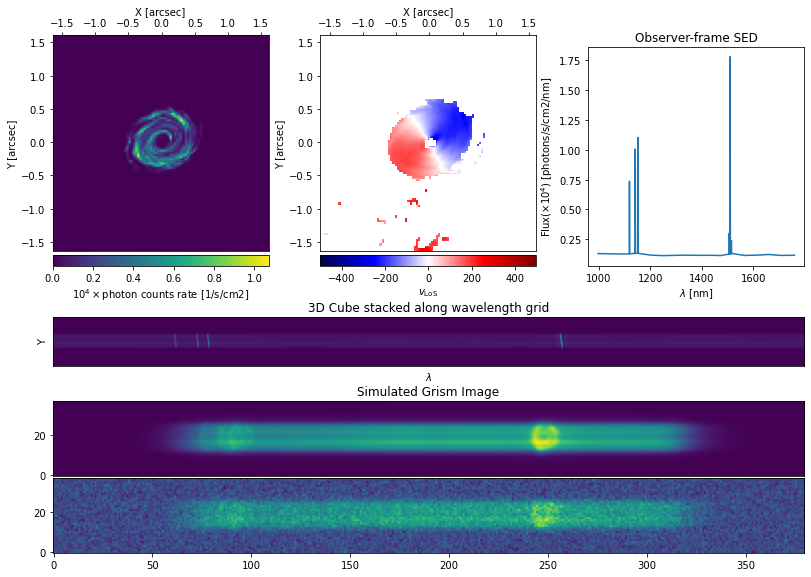

In [4]:
fig = plt.figure(figsize=[12,8])
w = 0.25
h = 0.4
dh = 0.05
dw = 0.06
ax1 = fig.add_axes([dw, 3*dh+1*h, w, h])
ax2 = fig.add_axes([2*dw+w, 3*dh+1*h, w, h])
ax3 = fig.add_axes([3*dw+2*w, 3*dh+1*h, w, h*0.95])

ax4 = fig.add_axes([dw, 1.7*dh+2*h/3, 3*w+2*dw, h/3])
ax5 = fig.add_axes([dw, dh+h/3, 3*w+2*dw, h/3])
ax6 = fig.add_axes([dw, dh, 3*w+2*dw, h/3])

_Nx = Gpars['model_dimension']['Nx']
_Ny = Gpars['model_dimension']['Ny']
_scale = Gpars['model_dimension']['scale']
extent = [-(_Nx/2+0.5)*_scale, (_Nx/2-0.5)*_scale,
          -(_Ny/2+0.5)*_scale, (_Ny/2-0.5)*_scale]
cube = subhalo.simGrismCube

cb = ax1.imshow(np.sum(cube.data, axis=0)*1e4, origin='lower', extent=extent)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="5%", pad=0.05,)
plt.colorbar(cb, cax=cax, orientation='horizontal', label=r'$10^4\times$photon counts rate [1/s/cm2]')
ax1.set(xlabel='X [arcsec]', ylabel='Y [arcsec]',)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top') 

cb = ax2.imshow(v_img, vmin=-500, vmax=500, cmap='seismic', origin='lower',
               extent=extent)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="5%", pad=0.05,)
plt.colorbar(cb, cax=cax, orientation='horizontal', label=r'$v_\mathrm{LoS}$')
ax2.set(xlabel='X [arcsec]', ylabel='Y [arcsec]')
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top') 

sed = grism.GrismSED(Gpars['sed'])
ax3.plot(np.mean(Gpars.lambdas, axis=1), sed(np.mean(Gpars.lambdas, axis=1))*1e4)
ax3.set(xlabel='$\lambda$ [nm]', ylabel=r'Flux($\times 10^4$) [photons/s/cm2/nm]',
       title='Observer-frame SED')
ax3.set_aspect('auto')

ax4.imshow(np.sum(cube.data, axis=1).T, origin='lower')
ax4.set(xticks=[], yticks=[], xlabel='$\lambda$', ylabel='Y', title='3D Cube stacked along wavelength grid')

ax5.imshow(img, origin='lower')
ax5.set(xticks=[], title='Simulated Grism Image')

ax6.imshow(img+noise/3, origin='lower')

In [11]:
cube

Selecting gas particles
Subsampling particle data.
Calculating position offsets
Discretizing positions
Calculating velocity offsets
Systematic velocity = 520.2106323242188 km/s


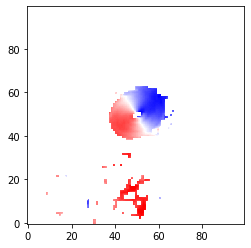

In [5]:
v_img = subhalo.generateVelocityMap(Gpars, rescale=0.1)
v_img = np.ma.masked_invalid(v_img)
plt.imshow(v_img, vmin=-500, vmax=500, cmap='seismic', origin='lower')

In [5]:
m.clear_observation()
grism.initialize_observations(1, [Gpars])

[-1/-1] Setting pixel response table
[-1/-1] Theory model cube:
	scale = 0.0325	dimension = (Nlam=1528, Nx=100, Ny=100)
[-1/-1] Dispersed image dimension:
	scale = 0.065	dimension = (Ny=38, Nx=380)
[-1/-1] Pixel res. table size = 22232400
[-1/-1] 1 observations in this list


In [6]:
img, noise = subhalo.to_grism(Gpars, rescale=0.25)

Generating 3d data cube
Selecting gas particles
Subsampling particle data.
Calculating position offsets
Discretizing positions
Calculating velocity offsets
Populating datacube with emission lines flux


 33%|█████████████████▎                                   | 3260/10000 [00:34<01:12, 93.54it/s]


Generating simulated grism image
cpp_get_dispersed_image 0 out of 1
Calling get_dispersed_image
Checking input dimension
Clean the output image
Setting OMP thread to 1
Looping
Dump local copy to the final answer


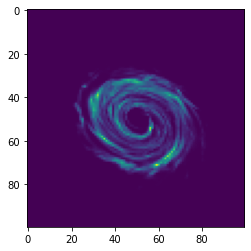

In [7]:
test = subhalo.simGrismCube
plt.imshow(np.sum(test.data, axis=0))

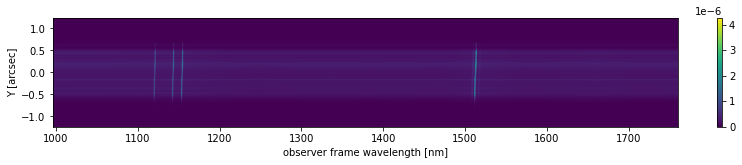

In [8]:
fig = plt.figure(figsize=[14,2])
cb = plt.imshow(np.sum(test.data, axis=1).T, 
    extent=[Gpars.lambdas[0][0], Gpars.lambdas[-1][0],
            -Gpars.conf['NAXIS2']/2*Gpars.conf['PIXSCALE'], 
            Gpars.conf['NAXIS2']/2*Gpars.conf['PIXSCALE']], aspect='auto')
plt.xlabel('observer frame wavelength [nm]')
plt.ylabel('Y [arcsec]')
plt.colorbar(cb, orientation='vertical')

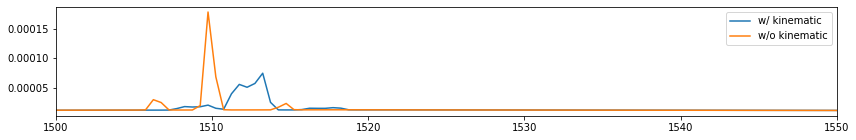

In [9]:
fig = plt.figure(figsize=(14,2))
plt.plot(np.mean(Gpars.lambdas, axis=1), np.sum(test.data, axis=(1,2)), label='w/ kinematic')
sed = grism.GrismSED(Gpars['sed'])
plt.plot(np.mean(Gpars.lambdas, axis=1), sed(np.mean(Gpars.lambdas, axis=1)), label='w/o kinematic')
plt.xlim(1500,1550)
plt.legend()

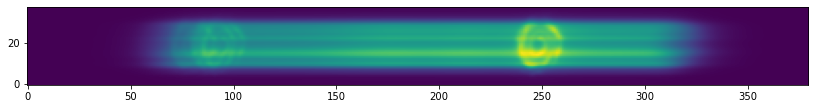

In [10]:
fig = plt.figure(figsize=[14,2])
plt.imshow(img, origin='lower')

Selecting gas particles
Subsampling particle data.
Calculating position offsets
Discretizing positions
Calculating velocity offsets


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., 681.5604248046875, 660.052490234375,
         629.661865234375],
        [--, --, --, ..., 679.91259765625, 685.4998168945312,
         650.5419921875],
        [--, --, --, ..., 671.5499877929688, 691.9678344726562,
         680.94384765625]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20)

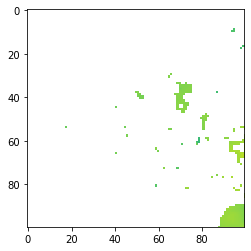

In [12]:
plt.imshow(v_img, vmin=-1000, vmax=1000)

In [3]:
#   - pixel scale [arcsec/pixel, scalar]
#   - vector of wavelength spaxel centers [angstroms]
#   - spectral resolution [ scalar float, lambda/delta_lambda]
#   - redshift (default to _requested_ subhalo redshift) [scalar float]
#   - dimensions of the datacube [nlam, nx, ny]
wave_grid = np.linspace(9000, 12000, 300)
dlam = wave_grid[1:] - wave_grid[:-1]
bandpasses = [gs.Bandpass(
            1.0, 'A', blue_limit=il-dl, red_limit=il+dl, zeropoint=22.5
            ) for il,dl in zip(wave_grid, dlam/2.)]

line_pars_dict = {
    'value': LINE_LAMBDAS['Ha'].value,
    'R': 461*(LINE_LAMBDAS['Ha']*(1+subhalo.redshift)/(1*u.micron)).to('1').value,
    'z': subhalo.redshift, 
    'unit': LINE_LAMBDAS['Ha'].unit,
}
sed_pars_dict = {
    'lblue': wave_grid[0],
    'lred': wave_grid[-1],
    'resolution': 10,
    'unit': u.Angstrom,
}
Ha_line = emission.EmissionLine(line_pars_dict, sed_pars_dict)
pars_dict = {
    'pix_scale': 0.11,
    'shape': [wave_grid.shape[0]-1, 60, 60],
    'emission_lines': [Ha_line],
    #'psf': ,
    'bandpasses': bandpasses,
}

pars = cube.CubePars(pars_dict)

dc = subhalo.to_cube(pars)

Choosing  indices
Reading particle data.
Subsampling particle data.
Calculating velocity offsets
Calculating position offsets
Centering
Discretizing positions
Populating datacube


100%|████████████████████████████████████████████████████| 3600/3600 [00:01<00:00, 1959.13it/s]


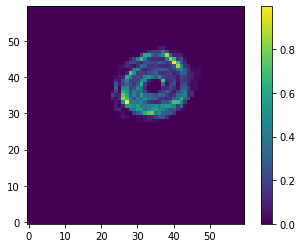

In [4]:
cb = plt.imshow(np.sum(dc._data, axis=0), origin='lower')
plt.colorbar(cb)

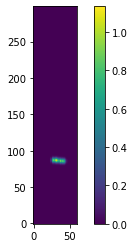

In [5]:
cb = plt.imshow(np.sum(dc._data, axis=1), origin='lower')
plt.colorbar(cb)

In [6]:
### Build GrismPars object
### Initialization
sampled_pars = [
    'g1',
    'g2',
    'theta_int',
    'sini',
    'v0',
    'vcirc',
    'rscale',
    ]
sampled_pars_value = [0.0, 0.0, -1.04, 0.86, 0.0, 300.0, 0.5]
sampled_pars_value_dict = {k:v for k,v in zip(sampled_pars, sampled_pars_value)}
meta_pars = {
    'g1': 'sampled',
    'g1': 'sampled',
    'theta_int': 'sampled',
    'sini': 'sampled',
    'units': {
        'v_unit': u.Unit('km/s'),
        'r_unit': u.Unit('arcsec')
        },
    'priors': {
        'g1': priors.GaussPrior(0., 0.1, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.1, clip_sigmas=2),
        'theta_int': priors.UniformPrior(-np.pi, np.pi),
        'sini': priors.UniformPrior(0, 1.),
        'v0': priors.GaussPrior(0.0, 30, clip_sigmas=5),
        #'vcirc': priors.UniformPrior(0, 800),
        'vcirc': priors.GaussPrior(300.0, 30, clip_sigmas=5),
        'rscale': priors.UniformPrior(0, 4),
        },
    'velocity': {
        'model': 'default',
        'v0': 'sampled',
        'vcirc': 'sampled',
        'rscale': 'sampled',
    },
    'intensity': {
        # For this test, use truth info
        'type': 'inclined_exp',
        'flux': 1.0, # counts
        'hlr': 0.5,
        },
    # 'marginalize_intensity': True,
    #'psf': gs.Gaussian(fwhm=0.13),
    'run_options': {
        #'remove_continuum': True,
        'use_numba': False
        },
    'model_dimension':{
        'Nx': 100,
        'Ny': 100,
        'scale': 0.0325, # arcsec
        'lambda_range': [1236.6, 1325.1], # 1190-1370
        'lambda_res': 0.5, # nm
        'lambda_unit': 'nm',
    },
    'sed':{
        'template': '../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 0.9513,
        'spectral_range': [500., 3000.], # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': [614, 2.6e-17],
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines':{
            'Ha': 1.25e-16,
            'O2': [1.0e-15, 1.2e-15],
            'O3_1': 1.0e-15,
            'O3_2': 1.2e-15,
        },
        # intrinsic linewidth in nm
        'line_sigma_int':{
            'Ha': 0.5,
            'O2': [0.2, 0.2],
            'O3_1': 0.2,
            'O3_2': 0.2,
        },
    },
    # observation configuration dict
    'obs_conf': {
        'OBSINDEX': 0,
        'INSTNAME': "HST/WCF3",
        'OBSTYPE': 1,
        'BANDPASS': "../data/Bandpass/HST/WFC3_IR_G141_1st.dat",
        'NAXIS': 2,
        'NAXIS1': 38, 
        'NAXIS2': 38,
        'PIXSCALE': 0.065,
        'RSPEC': 215,
        'PSFTYPE': "airy_mean",
        'PSFFWHM': 0.13,
        'DISPANG': 0.0,
        'OFFSET': -550.96322,
        'DIAMETER': 240.0,
        'EXPTIME': 5000,
        'GAIN': 1.0,
        'NOISETYP': 'ccd',
        'SKYLEVEL': 0.1,
        'RDNOISE': 20,
        'ADDNOISE': False,
    },
}

In [7]:
Gpars = grism.GrismPars(meta_pars)

In [8]:
_simcube = subhalo._generateGrismCube(Gpars)

Selecting gas particles
Subsampling particle data.
Calculating position offsets
Discretizing positions
Calculating velocity offsets
Populating datacube with emission lines flux


 58%|█████████████████████████████▉                      | 5755/10000 [00:26<00:19, 213.48it/s]


In [9]:
simcube = grism.GrismModelCube(_simcube, pars=Gpars)

In [18]:
with open("test_cube.pkl", 'wb') as fp:
    pickle.dump(simcube, fp)

In [8]:
with open("test_cube.pkl", 'rb') as fp:
    simcube = pickle.load(fp)
print("Initializing observation")
grism.initialize_observations(1, [Gpars])
img, noise = subhalo.to_grism(Gpars)

[-1/-1] Setting pixel response table
[-1/-1] Theory model cube:
	scale = 0.0325	dimension = (177, 100, 100)
[-1/-1] Dispersed image dimension:
	scale = 0.065	dimension = (38, 38)
[-1/-1] Pixel res. table size = 1727279
[-1/-1] 1 observations in this list


In [10]:
Gpars.obs_index

0

In [9]:
_img = np.zeros([Gpars.conf['NAXIS1'], Gpars.conf['NAXIS2']], dtype=np.float64, order='C')

In [10]:
m.get_image(Gpars.obs_index, simcube.data, _img, 
                    Gpars.lambdas, Gpars.bp_array)

cpp_get_dispersed_image 0 out of 1
Calling get_dispersed_image
Checking input dimension
Clean the output image
Setting OMP thread to 1
Looping
Dump local copy to the final answer


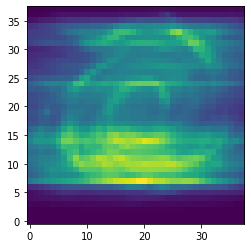

In [11]:
plt.imshow(_img, origin='lower')

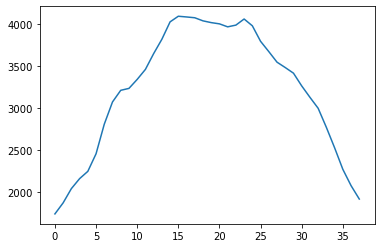

In [13]:
plt.plot(np.sum(_img, axis=0))

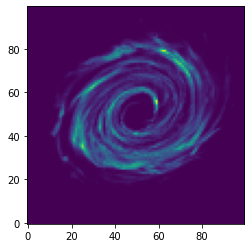

In [12]:
plt.imshow(np.sum(simcube.data, axis=0), origin='lower')

### Get the Grism Cube object

In [ ]:
### dict object to build GrismPars
# Note that this pars is used to generate TNG mock data
# Some parameters only applys in this branch, like `emission_lines`
grismpars_dict = {
    # required fields
    'pix_scale': 0.11, # 3d theory cube pixel scale in arcsec
    'bandpasses': bandpasses, # 3d model cube bandpass, can be a real bandpasses list or a dict
    'shape': [wave_grid.shape[0]-1, 60, 60], # shape of the 3d data cube
    # optional fields
    'psf': , # the PSF (but when to apply?)
    'emission_lines': [Ha_line], # which emission line to use? Note that each item is an emission line object
    'grism_conf': {
        'type': ,
        'bandpass': ,
        'instname': ,
        'Nx': ,
        'Ny': ,
        'pixscale':
        'diameter':
        'exptime':
        'gain': ,
        'noisetyp': ,
        'skylevel': ,
        'rdnoise': ,
        'addnoise': ,
        'psftype': ,
        'psffwhm': ,
        'Rspec': ,
        'dispang': ,
        'offset': ,
    }
}

In [ ]:
def _grism_photon_distribution(modelcube, modelmesh, image, image_coord, offset, Rspec, ):
    ''' distribute photons in the 3d model cube into 2d dispersed grism image
    
    Inputs:
    =======
        - modelcube: np.ndarray
            The 3d model cube. Values are in units of [photons/sec/cm2]
        - modelmesh: np.ndarray
            The 2d meshgrid of coordiates
    '''
    

## Scratch Below

In [27]:
PartG = subhalo._particleData['PartType0']
PartSW = subhalo._particleData['PartType4']

In [9]:
subhalo._particleData.keys()

<KeysViewHDF5 ['Header', 'PartType0', 'PartType1', 'PartType4', 'PartType5']>

In [11]:
subhalo._particleData['PartType0'].keys()

<KeysViewHDF5 ['CenterOfMass', 'Coordinates', 'Density', 'ElectronAbundance', 'EnergyDissipation', 'GFM_AGNRadiation', 'GFM_CoolingRate', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged', 'GFM_WindDMVelDisp', 'GFM_WindHostHaloMass', 'InternalEnergy', 'Machnumber', 'MagneticField', 'MagneticFieldDivergence', 'Masses', 'NeutralHydrogenAbundance', 'ParticleIDs', 'Potential', 'StarFormationRate', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>

In [26]:
subhalo._particleData['PartType4'].keys()

<KeysViewHDF5 ['BirthPos', 'BirthVel', 'Coordinates', 'GFM_InitialMass', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged', 'GFM_StellarFormationTime', 'GFM_StellarPhotometrics', 'Masses', 'ParticleIDs', 'Potential', 'StellarHsml', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>

In [18]:
subhalo._particleData['PartType0/Coordinates'][0]

array([ 7090.34009336, 23504.87221613, 19960.84156963])

In [19]:
subhalo._particleData['PartType0/CenterOfMass'][0]

array([ 7089.869, 23505.225, 19960.674], dtype=float32)

In [23]:
subhalo._particleData['PartType0/Velocities'][:]

array([[850.86584 , 554.5735  , 565.90466 ],
       [430.78275 ,  43.473965, 458.3545  ],
       [960.801   , 542.3647  , 810.2293  ],
       ...,
       [477.21945 , 410.59344 , 774.37366 ],
       [638.70496 , 578.7693  , 693.1923  ],
       [405.11935 , 245.05135 , 601.71936 ]], dtype=float32)

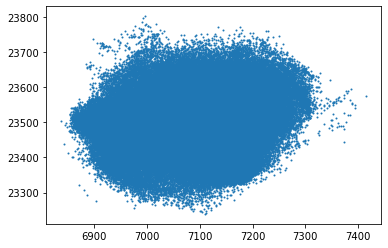

In [32]:
plt.scatter(PartSW['Coordinates'][:,0], PartSW['Coordinates'][:,1], 1)

In [34]:
attrs = vars(subhalo)

In [36]:
attrs.keys()

dict_keys(['base_url', 'cosmo', 'redshift', '_sim_name', '_snapshot', '_subhalo', '_cachefile', '_particleData', '_particleTemp', '_starFlux', '_line_flux'])

In [37]:
subhalo.redshift

0.5

In [40]:
 LINE_LAMBDAS['Ha'].value

6564.589

In [6]:
u.Angstrom

Unit("Angstrom")

In [11]:
(u.Unit('Angstrom')/u.cm).to('1')

1.0000000000000002e-08

In [20]:
class A:
    _req = ['a', 'b', 'c']
    def meth(self, text):
        print(text)
        
class B(A):
    _req = A._req.copy()
    _req.extend(['e', 'f', 'g'])
    def meth(self, text, flag):
        if flag:
            super(B, self).meth(text)
        else:
            print("Nope")
        

In [21]:
a = A()
b = B()
a.meth("Hello")
b.meth("Hello", True)
b.meth("Hello", False)

Hello
Hello
Nope


In [22]:
a._req

['a', 'b', 'c']

In [23]:
b._req

['a', 'b', 'c', 'e', 'f', 'g']

In [30]:
test_array = ['a', 'b', 'c']
test_array.remove('c')
print(test_array)
try:
    test_array.remove('e')
except:
    print('element not in the array')
print(test_array)

['a', 'b']
element not in the array
['a', 'b']


In [26]:
test_array

['a', 'b']

In [4]:
### Build GrismPars object
### Initialization
sampled_pars = [
    'g1',
    'g2',
    'theta_int',
    'sini',
    'v0',
    'vcirc',
    'rscale',
    ]
sampled_pars_value = [0.0, 0.0, -1.04, 0.86, 0.0, 300.0, 0.5]
sampled_pars_value_dict = {k:v for k,v in zip(sampled_pars, sampled_pars_value)}
meta_pars = {
    'g1': 'sampled',
    'g1': 'sampled',
    'theta_int': 'sampled',
    'sini': 'sampled',
    'units': {
        'v_unit': u.Unit('km/s'),
        'r_unit': u.Unit('arcsec')
        },
    'priors': {
        'g1': priors.GaussPrior(0., 0.1, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.1, clip_sigmas=2),
        'theta_int': priors.UniformPrior(-np.pi, np.pi),
        'sini': priors.UniformPrior(0, 1.),
        'v0': priors.GaussPrior(0.0, 30, clip_sigmas=5),
        #'vcirc': priors.UniformPrior(0, 800),
        'vcirc': priors.GaussPrior(300.0, 30, clip_sigmas=5),
        'rscale': priors.UniformPrior(0, 4),
        },
    'velocity': {
        'model': 'default',
        'v0': 'sampled',
        'vcirc': 'sampled',
        'rscale': 'sampled',
    },
    'intensity': {
        # For this test, use truth info
        'type': 'inclined_exp',
        'flux': 1.0, # counts
        'hlr': 0.5,
        },
    # 'marginalize_intensity': True,
    #'psf': gs.Gaussian(fwhm=0.13),
    'run_options': {
        #'remove_continuum': True,
        'use_numba': False
        },
    'model_dimension':{
        'Nx': 100,
        'Ny': 100,
        'scale': 0.0325, # arcsec
        'lambda_range': [1236.6, 1325.1], # 1190-1370
        'lambda_res': 0.5, # nm
        'lambda_unit': 'nm',
    },
    'sed':{
        'template': '../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 0.9513,
        'spectral_range': [500., 3000.], # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': [614, 2.6e-17],
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines':{
            'Ha': 1.25e-16,
            'O2': [1.0e-15, 1.2e-15],
            'O3_1': 1.0e-15,
            'O3_2': 1.2e-15,
        },
        # intrinsic linewidth in nm
        'line_sigma_int':{
            'Ha': 0.5,
            'O2': [0.2, 0.2],
            'O3_1': 0.2,
            'O3_2': 0.2,
        },
    },
    # observation configuration dict
    'obs_conf': {
        'OBSINDEX': 0,
        'INSTNAME': "HST/WCF3",
        'OBSTYPE': 1,
        'BANDPASS': "../data/Bandpass/HST/WFC3_IR_G141_1st.dat",
        'NAXIS': 2,
        'NAXIS1': 38, 
        'NAXIS2': 38,
        'PIXSCALE': 0.065,
        'RSPEC': 215,
        'PSFTYPE': "airy_mean",
        'PSFFWHM': 0.13,
        'DISPANG': 0.0,
        'OFFSET': -550.96322,
        'DIAMETER': 240.0,
        'EXPTIME': 5000,
        'GAIN': 1.0,
        'NOISETYP': 'ccd',
        'SKYLEVEL': 0.1,
        'RDNOISE': 20,
        'ADDNOISE': False,
    },
}

In [5]:
Gpars = grism.GrismPars(meta_pars)

In [9]:
test = subhalo._generateGrismCube(Gpars)

Selecting gas particles
Subsampling particle data.
Calculating position offsets
Discretizing positions
Calculating velocity offsets
Populating datacube with emission lines flux


 58%|█████████████████████████████▉                      | 5755/10000 [00:27<00:20, 210.91it/s]


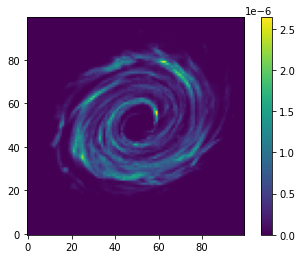

In [10]:
cb = plt.imshow(np.sum(test, axis=0), origin='lower')
plt.colorbar(cb)

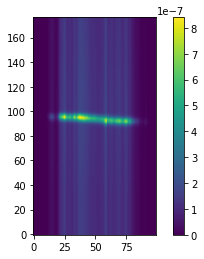

In [11]:
cb = plt.imshow(np.sum(test, axis=1), origin='lower')
plt.colorbar(cb)

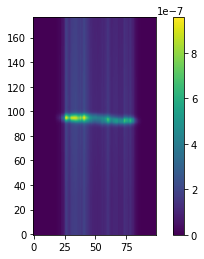

In [12]:
cb = plt.imshow(np.sum(test, axis=2), origin='lower')
plt.colorbar(cb)

In [ ]:
img, noise = subhalo.to_grism(Gpars)

Selecting gas particles
Subsampling particle data.
Calculating position offsets
Discretizing positions
Calculating velocity offsets
Populating datacube with emission lines flux


 58%|█████████████████████████████▉                      | 5755/10000 [00:26<00:19, 213.86it/s]

In [1]:
img

NameError: name 'img' is not defined

In [15]:
Gpars['obs_conf']

{'OBSINDEX': 0,
 'INSTNAME': 'HST/WCF3',
 'OBSTYPE': 1,
 'BANDPASS': '../data/Bandpass/HST/WFC3_IR_G141_1st.dat',
 'NAXIS': 2,
 'NAXIS1': 38,
 'NAXIS2': 38,
 'PIXSCALE': 0.065,
 'RSPEC': 215,
 'PSFTYPE': 'airy_mean',
 'PSFFWHM': 0.13,
 'DISPANG': 0.0,
 'OFFSET': -550.96322,
 'DIAMETER': 240.0,
 'EXPTIME': 5000,
 'GAIN': 1.0,
 'NOISETYP': 'ccd',
 'SKYLEVEL': 0.1,
 'RDNOISE': 20,
 'ADDNOISE': False,
 'MDNAXIS1': 177,
 'MDNAXIS2': 100,
 'MDNAXIS3': 100,
 'MDSCALE': 0.0325}

In [41]:
3//2

1

In [43]:
np.all(np.isfinite(subhalo._line_flux))

True

In [50]:
pars['emission_lines'][0].sed(LINE_LAMBDAS['Ha'].value*(1+subhalo.redshift))

array(0.01754028)

In [60]:
a = 1*u.km/u.s
(a/const.c).to('1')

<Quantity 3.33564095e-06>

In [10]:
_sed = grism.GrismSED(Gpars['sed'])

In [11]:
isinstance([1,2,3]*u.m, u.Quantity)

True

In [12]:
(1*u.m).to(_sed.spectrum.wave_type).value

999999999.9999999

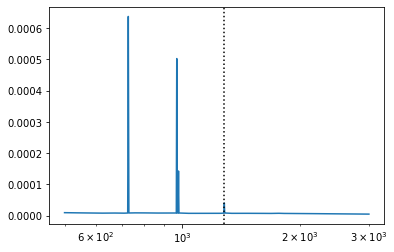

In [24]:
lam = np.linspace(_sed.spectrum.blue_limit, _sed.spectrum.red_limit, 1000)
plt.semilogx(lam, _sed(lam))
plt.axvline(656.4589*1.9513, color='k', ls=':')

In [28]:
np.mean(pars['wavelengths']*u.m, axis=1)

<Quantity [ 9000.        ,  9010.03344482,  9020.06688963,  9030.10033445,
            9040.13377926,  9050.16722408,  9060.2006689 ,  9070.23411371,
            9080.26755853,  9090.30100334,  9100.33444816,  9110.36789298,
            9120.40133779,  9130.43478261,  9140.46822742,  9150.50167224,
            9160.53511706,  9170.56856187,  9180.60200669,  9190.63545151,
            9200.66889632,  9210.70234114,  9220.73578595,  9230.76923077,
            9240.80267559,  9250.8361204 ,  9260.86956522,  9270.90301003,
            9280.93645485,  9290.96989967,  9301.00334448,  9311.0367893 ,
            9321.07023411,  9331.10367893,  9341.13712375,  9351.17056856,
            9361.20401338,  9371.23745819,  9381.27090301,  9391.30434783,
            9401.33779264,  9411.37123746,  9421.40468227,  9431.43812709,
            9441.47157191,  9451.50501672,  9461.53846154,  9471.57190635,
            9481.60535117,  9491.63879599,  9501.6722408 ,  9511.70568562,
            9521.73913043

In [29]:
Doppler = np.ones(100)
Doppler.shape

(100,)

In [31]:
wave = np.mean(pars.lambdas, axis=1)
wave.shape

(299,)

In [34]:
ans = wave*Doppler[:,np.newaxis]
ans.shape

(100, 299)

In [60]:
x = np.array([[1,2,3],[4,5,6]])

In [61]:
x.shape

(2, 3)

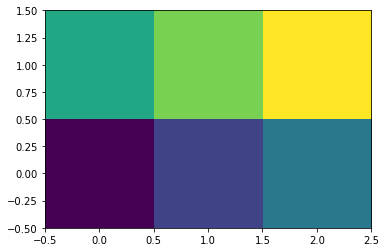

In [64]:
plt.imshow(x, origin='lower')

# 2. SED Modeling

The continuum is generated by `FSPS` with the following settings
- Padova isochrones
- MILES stellar library
- Chabrier IMG
- Each stellar particle is modeled as a simple stellar population (SSP), such that all star formed at the same time with the same metallicity as recorded in the simulation
- [optional] use the foreground gas cells within 30 pkpc of simulated galaxies to model the dust attenuation
- do not add line emission
- spatial smoothing (instrument psf)
- spectral resolution matching: smoothed with a Gaussian kernel of $sigma=\sqrt{\sigma_{gal}^2+\sigma_{inst}^2-sigma_{model}^2}$. They set $\sigma_{inst}=40 km/s$ and $\sigma_{model}=70 km/s$ (spectra template resolution). $\sigma_{gal}$ is randomly choosen from real data.
- stellar mass calculated by summing up stellar particles within 30 pkpc in a 3D spherical aperture. 

Related particle properties in illustrisTNG
- PartType4: stars / wind particles
    - `GFM_InitialMass`: $10^{10}M_\odot/h$, Mass of this star particle when it was formed (will subsequently decrease due to stellar evolution).
    - `GFM_Metallicity`: Inherited from the gas cell spawning/converted into this star, at the time of birth. The ratio $M_Z/M_\mathrm{total}$ where $M_Z$ is the total mass all metal elements (above He). Is NOT in solar units. To convert to solar metallicity, divide by 0.0127 (the primordial solar metallicity).
    - `GFM_StellarFormationTime`: The exact time (given as the scalefactor) when this star was formed. **Note: The only differentiation between a real star (>0) and a wind phase gas cell (<=0) is the sign of this quantity.**
    - `Masses`: $10^{10}M_\odot/h$, Mass of this star or wind phase cell.
    - `Velocities`: $km\sqrt{a}/s$, Spatial velocity. Multiply this value by $\sqrt{a}$ to obtain peculiar velocity.
    - `Coordinates`: $ckpc/h$, Spatial position within the **periodic** simulation domain of BoxSize. Comoving coordinate.

In [2]:
### Build GrismPars object
### Initialization
sampled_pars = [
    'g1',
    'g2',
    'theta_int',
    'sini',
    'v0',
    'vcirc',
    'rscale',
    ]
sampled_pars_value = [0.0, 0.0, -1.04, 0.86, 0.0, 300.0, 0.5]
sampled_pars_value_dict = {k:v for k,v in zip(sampled_pars, sampled_pars_value)}
meta_pars = {
    'g1': 'sampled',
    'g1': 'sampled',
    'theta_int': 'sampled',
    'sini': 'sampled',
    'units': {
        'v_unit': u.Unit('km/s'),
        'r_unit': u.Unit('arcsec')
        },
    'priors': {
        'g1': priors.GaussPrior(0., 0.1, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.1, clip_sigmas=2),
        'theta_int': priors.UniformPrior(-np.pi, np.pi),
        'sini': priors.UniformPrior(0, 1.),
        'v0': priors.GaussPrior(0.0, 30, clip_sigmas=5),
        #'vcirc': priors.UniformPrior(0, 800),
        'vcirc': priors.GaussPrior(300.0, 30, clip_sigmas=5),
        'rscale': priors.UniformPrior(0, 4),
        },
    'velocity': {
        'model': 'default',
        'v0': 'sampled',
        'vcirc': 'sampled',
        'rscale': 'sampled',
    },
    'intensity': {
        # For this test, use truth info
        'type': 'inclined_exp',
        'flux': 1.0, # counts
        'hlr': 0.5,
        },
    # 'marginalize_intensity': True,
    #'psf': gs.Gaussian(fwhm=0.13),
    'run_options': {
        #'remove_continuum': True,
        'use_numba': False
        },
    'model_dimension':{
        'Nx': 100,
        'Ny': 100,
        'scale': 0.0325, # arcsec
        #'lambda_range': [1236.6, 1325.1], # 1190-1370
        'lambda_range': [996,1760],
        'lambda_res': 0.5, # nm
        'lambda_unit': 'nm',
    },
    'sed':{
        'template': '../data/Simulation/GSB2.spec',
        'wave_type': 'Ang',
        'flux_type': 'flambda',
        'z': 0.9513,
        'z': 1.3,
        'spectral_range': [500., 3000.], # nm
        # obs-frame continuum normalization (nm, erg/s/cm2/nm)
        'obs_cont_norm': [614, 4.6e-17],
        # a dict of line names and obs-frame flux values (erg/s/cm2)
        'lines':{
            'O2': [1.0e-16, 1.2e-16],
            'Hb': 0.8e-16,
            'O3_1': 1.0e-16,
            'O3_2': 1.2e-16,
            'N2_1': 0.2e-16,
            'Ha': 1.5e-16,
            'N2_2': 0.1e-16,
        },
        # intrinsic linewidth in nm
        'line_sigma_int':{
            'O2': [0.1, 0.1],
            'Hb': 0.1,
            'O3_1': 0.1,
            'O3_2': 0.1,
            'N2_1': 0.1,
            'Ha': 0.1,
            'N2_2': 0.1,
        },
    },
    # observation configuration dict
    'obs_conf': {
        'OBSINDEX': 0,
        'INSTNAME': "HST/WCF3",
        'OBSTYPE': 1,
        'BANDPASS': "../data/Bandpass/HST/WFC3_IR_G141_1st.dat",
        'NAXIS': 2,
        'NAXIS1': 380,# Nx 
        'NAXIS2': 38,# Ny
        'PIXSCALE': 0.065,
        'RSPEC': 215,
        'PSFTYPE': "airy_mean",
        'PSFFWHM': 0.13,
        'DISPANG': np.pi/2. * 0.0,
        'OFFSET': -550.96322,
        'DIAMETER': 240.0,
        'EXPTIME': 500,
        'GAIN': 1.0,
        'NOISETYP': 'ccd',
        'SKYLEVEL': 0.1,
        'RDNOISE': 20,
        'ADDNOISE': False,
    },
}
mid_lambda = np.mean(meta_pars['model_dimension']['lambda_range'])
meta_pars['obs_conf']['OFFSET'] = -(mid_lambda*meta_pars['obs_conf']['RSPEC']/500)
print(meta_pars['obs_conf']['OFFSET'])
Gpars = grism.GrismPars(meta_pars)

-592.54


In [3]:
rescale=0.15

subhalo = ts()
subhalo.set_subhalo(subhaloid=2, redshift=0.5, move_to_redshift=Gpars['sed']['z'])

closest snapshot to desired redshift 0.5 is at http://www.tng-project.org/api/TNG50-1/snapshots/67/ 


Lookback time at z=0.5 is t0=5.196239527320522 Gyr
CPU times: user 1min 5s, sys: 220 ms, total: 1min 5s
Wall time: 1min 5s


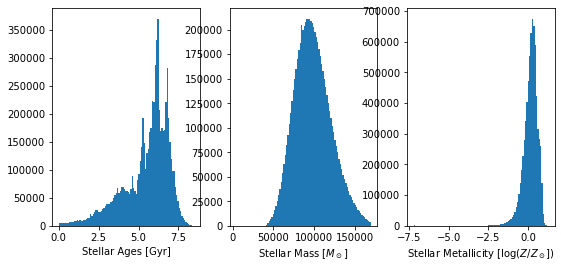

In [6]:
# Some input parameters to get stellar continuum
fig, axes = plt.subplots(1,3, figsize=(12,4))
# 1. Star formation history
GFM_SFT = subhalo.starPrtl['GFM_StellarFormationTime'][:]
sp_id = np.where(GFM_SFT>0)[0] # get stellar particles, not wind
sp_sfz = 1.0/GFM_SFT[sp_id]-1.0
t0 = subhalo.cosmo.lookback_time(0.5)#Gyr
print(f'Lookback time at z={0.5} is t0={t0}')
%time GFM_SFT = (subhalo.cosmo.lookback_time(sp_sfz) - t0).to('Gyr').value
axes[0].hist(GFM_SFT, bins=100)
axes[0].set(xlabel='Stellar Ages [Gyr]')

# 2. Stellar mass function
GFM_SM = subhalo.starPrtl['GFM_InitialMass'][:]*1e10/subhalo.cosmo.h # solar mass
GFM_SM = GFM_SM[sp_id]
axes[1].hist(GFM_SM, bins=100)
axes[1].set(xlabel=r'Stellar Mass [$M_\odot$]')

# 3. Metallicity distribution
# get the metallicity log(Z/Z_sol)
GFM_Z = np.log10(subhalo.starPrtl['GFM_Metallicity'][:]/0.0127) # solar mass
axes[2].hist(GFM_Z, bins=100)
axes[2].set(xlabel=r'Stellar Metallicity [log($Z/Z_\odot$])')

plt.show()

In [11]:
# get a "weighted mean sed"
mean_SFT = np.average(GFM_SFT, weights=GFM_SM)
mean_Z = np.average(GFM_Z, weights=GFM_SM)
mean_SM = np.average(GFM_SM)
#print(mean_SFT, mean_Z)
print(mean_SFT, mean_Z)

5.478140481780379 0.15846513


3.846e+33


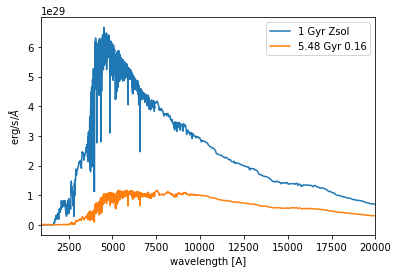

In [26]:
from astropy.constants import iau2012 as const
sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=1,
                            sfh=0, logzsol=0.0, nebemlineinspec=False, 
                            add_agb_dust_model=False,add_dust_emission=False,
                            smooth_velocity=False,
                            dust_type=2, dust2=0.2, imf_type=1)
wave1, spec1 = sp.get_spectrum(tage=1, peraa=True)

sp.params['logzsol'] = mean_Z
wave2, spec2 = sp.get_spectrum(tage=mean_SFT, peraa=True)

Lsun = (const.L_sun).to('erg s-1').value
print(Lsun)

plt.plot(wave1, spec1*Lsun, label='1 Gyr Zsol')
plt.plot(wave2, spec2*Lsun, label='%.2f Gyr %.2f'%(mean_SFT, mean_Z))
ax = plt.gca()
ax.set(xlim=[900, 20000],xlabel='wavelength [A]', ylabel=r'erg/s$/\AA$')
plt.legend()